# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from scipy.optimize import minimize

sns.set_style('darkgrid')

In [15]:
# Choose stocks from different industries
tickers = ['AAPL', 'TSLA', 'JNJ', 'NVDA', 'JPM', 'WMT', 'XOM', 'T']

start_date = dt.datetime.today() - dt.timedelta(days=2*365)
end_date = dt.datetime.today()

# Download Adjusted Close prices
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data.head()

[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,JNJ,JPM,NVDA,T,TSLA,WMT,XOM
Date,,,,,,,,
2023-06-05,177.799820,148.670212,132.427399,39.145580,13.651740,217.610001,48.733215,98.281525
2023-06-06,177.433487,148.538727,132.665436,38.628910,13.900114,221.309998,48.726707,99.084282
2023-06-07,176.057281,148.858032,133.950775,37.454552,14.281548,224.570007,48.798283,101.305862
2023-06-08,178.780014,150.491974,133.988846,38.488991,14.254936,234.860001,49.504227,100.988503
2023-06-09,179.166153,150.257187,134.255447,38.748844,14.148489,244.399994,49.803516,100.241760


In [16]:
# Daily log returns
returns = np.log(data / data.shift(1)).dropna()
returns.head()

Ticker,AAPL,JNJ,JPM,NVDA,T,TSLA,WMT,XOM
Date,,,,,,,,
2023-06-06,-0.002062,-0.000885,0.001796,-0.013287,0.018030,0.016860,-0.000134,0.008135
2023-06-07,-0.007786,0.002147,0.009642,-0.030873,0.027071,0.014623,0.001468,0.022173
2023-06-08,0.015347,0.010917,0.000284,0.027244,-0.001865,0.044802,0.014363,-0.003138
2023-06-09,0.002158,-0.001561,0.001988,0.006729,-0.007495,0.039817,0.006028,-0.007422
2023-06-12,0.015518,-0.000688,-0.000071,0.018198,-0.001255,0.021974,0.006576,-0.009074


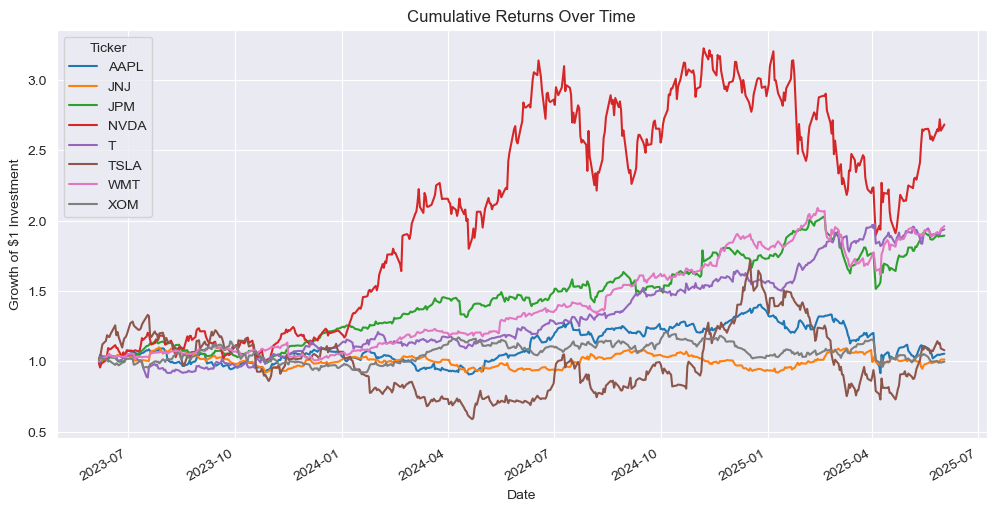

In [18]:
cumulative_returns = (1 + returns).cumprod()
cumulative_returns.plot(figsize=(12, 6))
plt.title("Cumulative Returns Over Time")
plt.ylabel("Growth of $1 Investment")
plt.show()

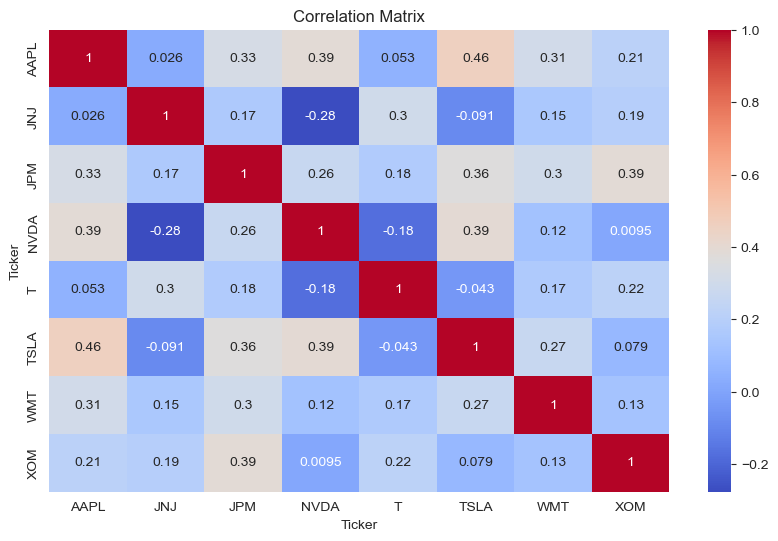

Ticker
TSLA    0.621115
NVDA    0.519547
AAPL    0.273157
T       0.233988
JPM     0.232933
XOM     0.222968
WMT     0.207422
JNJ     0.176013
dtype: float64

In [19]:
annual_volatility = returns.std() * np.sqrt(252)
correlation_matrix = returns.corr()

# Show as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

annual_volatility.sort_values(ascending=False)

In [24]:
# Annualized covariance matrix
cov_matrix = returns.cov() * 252

def portfolio_volatility(weights, cov_matrix=cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns) * 252

def get_constraints(min_w=0.05, max_w=0.35):
    return (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.min(x) - min_w},
        {'type': 'ineq', 'fun': lambda x: max_w - np.max(x)}
    )

mean_daily_returns = returns.mean()

In [25]:
n_assets = len(tickers)
init_guess = np.array([1/n_assets] * n_assets)

constraints = get_constraints(min_w=0.05, max_w=0.35)

low_risk_result = minimize(portfolio_volatility, init_guess, constraints=constraints)
low_risk_weights = low_risk_result.x

# Show portfolio
print("Low-Risk Portfolio Weights:")
for t, w in zip(tickers, low_risk_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {low_risk_result.fun:.4f}")

Low-Risk Portfolio Weights:
AAPL: 0.0501
TSLA: 0.3500
JNJ: 0.0502
NVDA: 0.0501
JPM: 0.1511
WMT: 0.0500
XOM: 0.1546
T: 0.1439
Portfolio Volatility: 0.1242


In [ ]:
def neg_portfolio_volatility(weights, cov_matrix=cov_matrix):
    return -np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def neg_return(weights, mean_returns=mean_daily_returns):
    #return -np.dot(weights, mean_returns)
    return -np.dot(weights, mean_returns) * 252

In [27]:
# Relax max weight constraint to allow concentrated positions
constraints_risky = get_constraints(min_w=0.01, max_w=0.80)

high_risk_result = minimize(neg_portfolio_volatility, init_guess, constraints=constraints_risky)
high_risk_weights = high_risk_result.x

print("High-Risk Portfolio Weights:")
for t, w in zip(tickers, high_risk_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {-high_risk_result.fun:.4f}")

High-Risk Portfolio Weights:
AAPL: 0.0095
TSLA: 0.0094
JNJ: 0.0094
NVDA: 0.1441
JPM: 0.0094
WMT: 0.7995
XOM: 0.0094
T: 0.0094
Portfolio Volatility: 0.5329


In [28]:
# Try maximizing expected return subject to less conservative bounds
constraints_return = get_constraints(min_w=0.01, max_w=0.8)

high_return_result = minimize(neg_return, init_guess, constraints=constraints_return)
high_return_weights = high_return_result.x
high_return = -high_return_result.fun
high_volatility = portfolio_volatility(high_return_weights)

print("High-Return Portfolio Weights:")
for t, w in zip(tickers, high_return_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {high_volatility:.4f}")

High-Return Portfolio Weights:
AAPL: 0.0100
TSLA: 0.0100
JNJ: 0.0100
NVDA: 0.8000
JPM: 0.0729
WMT: 0.0100
XOM: 0.0771
T: 0.0100
Portfolio Volatility: 0.4193


In [31]:
low_risk_ret = portfolio_return(low_risk_weights, mean_daily_returns)
high_risk_ret = portfolio_return(high_risk_weights, mean_daily_returns)
high_return_ret = portfolio_return(high_return_weights, mean_daily_returns)

print(f"Low-Risk Return: {low_risk_ret:.4f}, Volatility: {low_risk_result.fun:.4f}")
print(f"High-Risk Return: {high_risk_ret:.4f}, Volatility: {-high_risk_result.fun:.4f}")
print(f"High-Return Return: {high_return_ret:.4f}, Volatility: {portfolio_volatility(high_return_weights):.4f}")

Low-Risk Return: 0.1858, Volatility: 0.1242
High-Risk Return: 0.2858, Volatility: 0.5329
High-Return Return: 0.5684, Volatility: 0.4193
